### Setup TPU and check the status

Reference: https://www.tensorflow.org/guide/tpu?hl=nl_NL

In [0]:
import os
import pprint
import tensorflow as tf

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.43.79.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.43.79.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


Verify that TPU is connected, and all 8 cores are available for processing

In [0]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.compat.v1.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.43.79.146:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 2375147293438252517),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, -532119323692487571),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, -3561570391023555038),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4349917188465517158),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, -5813432436499026996),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 2421955616542867023),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 3611397447339389952),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, -3381240001928287135),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, -264022250468

# Load all required libraries

In [0]:
# import all usual libraries and modules

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
from PIL import Image
import os

In [0]:
# import TensorFlow and related modules

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Dropout, LeakyReLU, BatchNormalization, Input, Concatenate, Activation, concatenate
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


In [0]:
def plot_comparison(original, filtered, title_filtered):
  
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load our grayscale(L) and AB images from files

In [0]:
images_gray = np.load('/content/gdrive/My Drive/Colab Notebooks/image-colorization/l/gray_scale.npy')
images_lab1 = np.load('/content/gdrive/My Drive/Colab Notebooks/image-colorization/ab/ab/ab1.npy')
images_lab2 = np.load('/content/gdrive/My Drive/Colab Notebooks/image-colorization/ab/ab/ab2.npy')
images_lab3 = np.load('/content/gdrive/My Drive/Colab Notebooks/image-colorization/ab/ab/ab3.npy')

In [0]:
# concatenate these split up files into one
images_lab = np.concatenate((images_lab1, images_lab2))
images_lab = np.concatenate((images_lab, images_lab3))

# clean up unnecessary garbage vars
del images_lab1, images_lab2, images_lab3

# Check counts of images in each dataset, for confirmation

In [0]:
len(images_gray)

25000

In [0]:
len(images_lab)

25000

# Verify, based on shape, that grayscale images(L) and AB images have expected layers in them

In [0]:
images_gray[0].shape

(224, 224)

In [0]:
images_lab[0].shape

(224, 224, 2)

# Make a function to grab the grayscale(L), A and B components of our overall LAB image

- This function also converts the aggregated (complete) LAB image into a RGB format prior to returning

In [0]:
def create_color_image_from_lab_grayscale(img_gray, img_lab):
    # import required packages
    import cv2
    import numpy as np
    
    # create a basic numpy array to contain our disaggregated image
    img = np.zeros((224, 224, 3))
    
    # add our grayscale part to layer one ('L')
    img[:, :, 0] = img_gray
    
    # add the two ('A' and 'B') layers from lab on top of the grayscale level one to get the "complete function"
    img[:, :, 1:] = img_lab
    img = img.astype('uint8')
    img_ = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img_

# Test out the grayscale image

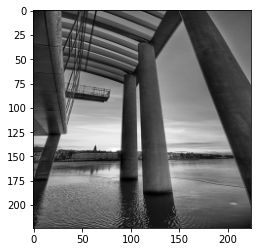

In [0]:
plt.imshow(images_gray[5], cmap="gray")

# Colorized (aggregated) image

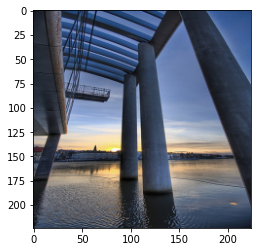

In [0]:
img_complete = create_color_image_from_lab_grayscale(images_gray[5],images_lab[5])
plt.imshow(img_complete)

# Define another function to generate a batch of images instead of just one image for our use

In [0]:
def get_rbg_from_lab(gray_imgs, ab_imgs, n = 10):
    
    imgs = np.zeros((n, 224, 224, 3))
    imgs[:, :, :, 0] = gray_imgs[0:n:]
    imgs[:, :, :, 1:] = ab_imgs[0:n:]
    
    imgs = imgs.astype("uint8")
    
    imgs_ = []
    for i in range(0, n):
        imgs_.append(cv2.cvtColor(imgs[i], cv2.COLOR_LAB2RGB))

    imgs_ = np.array(imgs_)

    print(imgs_.shape)
    
    return imgs_

(6, 224, 224, 3)


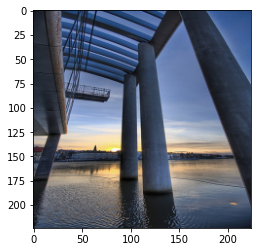

In [0]:
temp = get_rbg_from_lab(images_gray, images_lab, n=6)
plt.imshow(temp[5])

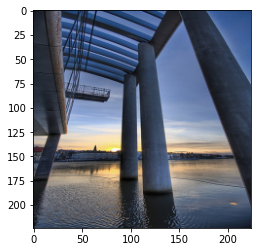

In [0]:
plt.imshow(create_color_image_from_lab_grayscale(images_gray[5],images_lab[5]))

# Try out a new model for experimentation, using the MobileNetV2

In [0]:
def create_model(image_shape):
    # Prepare the kernel initializer values
    weight_init = RandomNormal(stddev=0.02)
    # Prepare the Input layer
    net_input = Input((image_shape))
    # Download mobile net, and use it as the base.
    mobile_net_base = MobileNetV2(
        include_top=False,
        input_shape=image_shape,
        weights='imagenet'
    )
    mobilenet = mobile_net_base(net_input)
    
    # Encoder block #
    # 224x224
    conv1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(net_input)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 112x112
    conv2 = Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(conv1)
    conv2 = LeakyReLU(alpha=0.2)(conv2)

    # 112x112
    conv3 = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv2)
    conv3 =  Activation('relu')(conv3)

    # 56x56
    conv4 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv3)
    conv4 = Activation('relu')(conv4)

    # 28x28
    conv4_ = Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(conv4)
    conv4_ = Activation('relu')(conv4_)

    # 28x28
    conv5 = Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv4_)
    conv5 = Activation('relu')(conv5)

    # 14x14
    conv5_ = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv5)
    conv5_ = Activation('relu')(conv5_)
    
    #7x7
    # Fusion layer - Connects MobileNet with our encoder
    conc = concatenate([mobilenet, conv5_])
    fusion = Conv2D(512, (1, 1), padding='same', kernel_initializer=weight_init)(conc)
    fusion = Activation('relu')(fusion)
    
    # Skip fusion layer
    skip_fusion = concatenate([fusion, conv5_])
    
    # Decoder block #
    # 7x7
    decoder = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_fusion)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # Skip layer from conv5 (with added dropout)
    skip_4_drop = Dropout(0.25)(conv5)
    skip_4 = concatenate([decoder, skip_4_drop])
    
    # 14x14
    decoder = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_4)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # Skip layer from conv4_ (with added dropout)
    skip_3_drop = Dropout(0.25)(conv4_)
    skip_3 = concatenate([decoder, skip_3_drop])
    
    # 28x28
    decoder = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_3)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # 56x56
    decoder = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # 112x112
    decoder = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)

    # 112x112
    decoder = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)
    
    # 224x224
    # Ooutput layer, with 2 channels (a and b)
    output_layer = Conv2D(2, (1, 1), activation='tanh')(decoder)

    model = Model(net_input, output_layer)
    
    return model

In [0]:
# Compile and optimize a model for TF 2.0, ensure compatibility with TPU
strategy = tf.distribute.experimental.TPUStrategy(resolver)
with strategy.scope():
  model = create_model((224, 224, 3))
  model.compile(Adam(lr=0.001), loss='mse', metrics=['accuracy'])

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


9412608/9406464 [==============================] - 0s 0us/step


In [0]:
# define function for training our model, by taking in input datasets and preprocessing them as necessary

def train(model, gray, ab, epochs, batch_size, steps_per_epoch):
    # setup the training input data (grayscale images)
    train_in = gray

    # convert the shape from (224, 224, 1) to (224, 224, 3) by copying the value to match MobileNet's requirements
    train_in = np.repeat(train_in[..., np.newaxis], 3, -1)
    
    train_out = ab
    # normalize the data
    train_in = (train_in.astype('float32') - 127.5) / 127.5
    train_out = (train_out.astype('float32') - 127.5) / 127.5

    history = model.fit(
        train_in,
        train_out,
        epochs=epochs,
        validation_split=0.05,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch
    )
    
    return history

In [0]:
# train model using the below configs, and training dataset

for i in range(0, 25000, 2000):
  print(" ")
  print("<<< Training started for image numbers ", i, " to ", i+2000, " in the training dataset >>>")
  print(" ")

  BATCH_SIZE = 128 #(8 * 8^n)
  EPOCHS = 400
  STEPS_PER_EPOCH = 15 #(Number of cases / Batch size)
  START = i

  # delete currently trained model
  del model
  print("Deleted prior trained model...")

  # Compile and optimize a model for TF 2.0, ensure compatibility with TPU
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
  with strategy.scope():
    model = create_model((224, 224, 3))
    model.compile(Adam(lr=0.001), loss='mse', metrics=['accuracy'])
  print("Compiled model as per defined network structure...")

  # load weights from training on previous subset of data
  if i != 0:
    model.load_weights('/content/gdrive/My Drive/Colab Notebooks/image-colorization/trained_using_TPU_latest.h5')
    print("Loaded prior weights...")
  if i != 24000:
    history = train(model, images_gray[START:START+2000], images_lab[START:START+2000], EPOCHS, BATCH_SIZE, STEPS_PER_EPOCH)
  else:
    history = train(model, images_gray[START:], images_lab[START:], EPOCHS, BATCH_SIZE, STEPS_PER_EPOCH)
  print(" ")
  print("<<< Training over for ", i, " to ", i+2000, " images in training dataset >>>")
  print(" ")

  # save out weights post training on this subset of data
  model.save_weights('/content/gdrive/My Drive/Colab Notebooks/image-colorization/trained_using_TPU_latest.h5')
  print("Saved out weights post-training...")

Now that the model has run, and it has been saved by itself alongwith the weights, we can make predictions for samples of grayscales images

In [0]:
def get_pred(model, image_l):
    # repeat the L value to match input shape
    image_l_R = np.repeat(image_l[..., np.newaxis], 3, -1)
    image_l_R = image_l_R.reshape((1, 224, 224, 3))

    # normalize the input
    image_l_R = (image_l_R.astype('float32') - 127.5) / 127.5

    # make prediction
    prediction = model.predict(image_l_R)

    # normalize the output
    pred = (prediction[0].astype('float32') * 127.5) + 127.5
    return pred

In [0]:
def get_LAB(image_l, image_ab):
    image_l = image_l.reshape((224, 224, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb

In [0]:
def create_sample(model, images_gray, amount):
    path = "/content/gdrive/My Drive/Colab Notebooks/image-colorization/folder_to_save_TPU_results/"
    samples = []
    for i in range(amount):
        # select random images
        r = random.randint(0, images_gray.shape[0] - 1)

        # get the model's prediction
        pred = get_pred(model, images_gray[r])

        # combine input and output to LAB image
        image = get_LAB(images_gray[r], pred)

        # get number of images in output folder
        count = len(os.listdir(path))

        # create new combined image, save it
        new_image = Image.new('RGB', (448, 224))
        gray_image = Image.fromarray(images_gray[r])
        new_image.paste(gray_image, (0,0))
        new_image.paste(image, (224, 0))

        new_image.save(path + str(count)+('_%i.png' % r))
        samples.append(new_image)
    return samples

In [0]:
samples = create_sample(model, images_gray, 25000)
for image in samples:
    #plt.figure()
    #plt.imshow(np.array(image))
    continue

In [0]:
samples = create_sample(model, images_gray[:3000], 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))

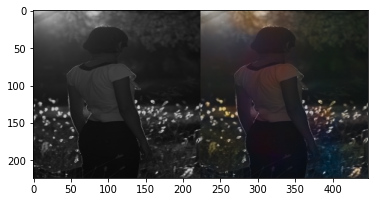

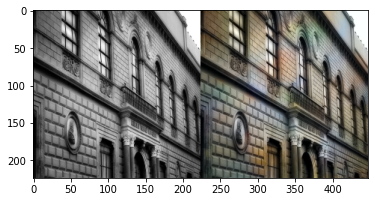

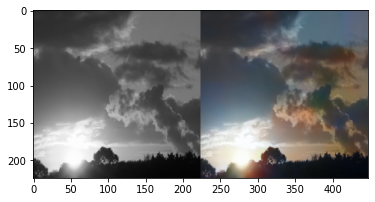

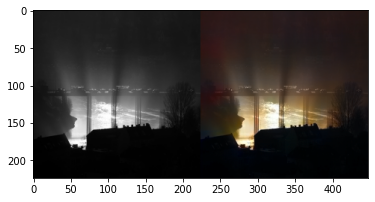

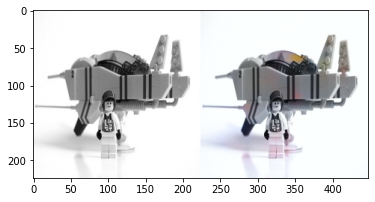

In [0]:
samples = create_sample(model, images_gray, 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))

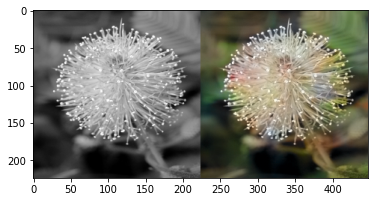

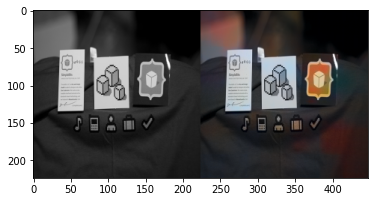

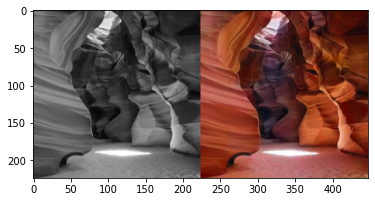

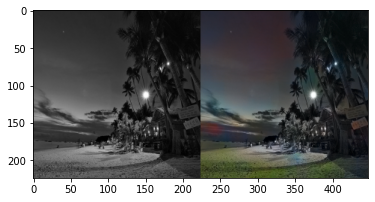

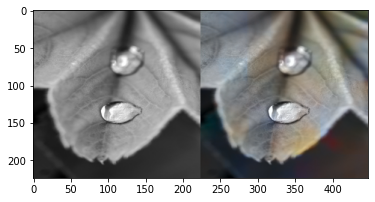

In [0]:
samples = create_sample(model, images_gray, 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))

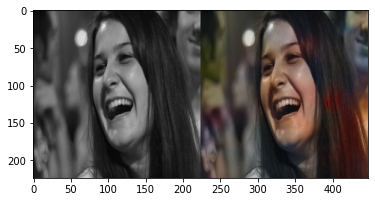

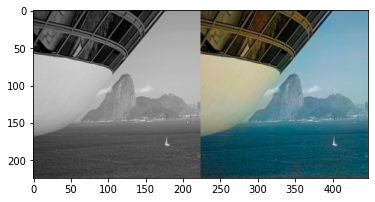

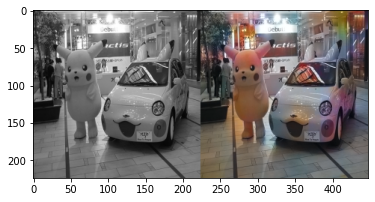

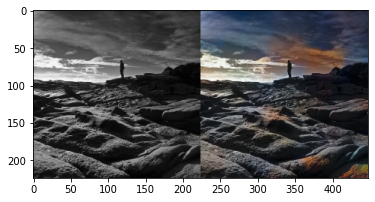

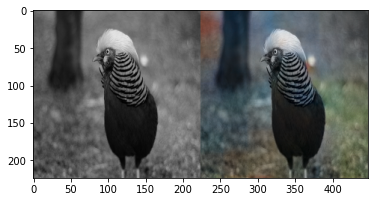

In [0]:
samples = create_sample(model, images_gray, 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))

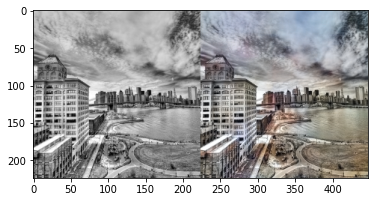

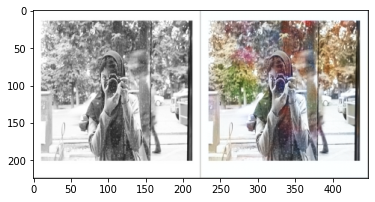

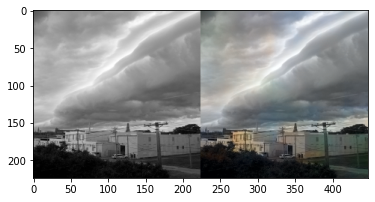

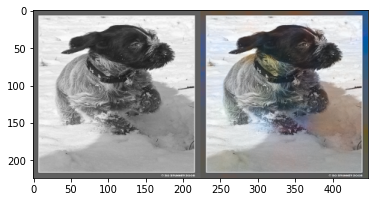

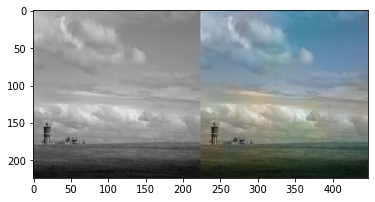

In [0]:
samples = create_sample(model, images_gray, 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))

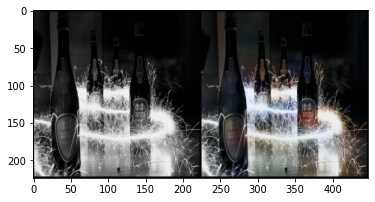

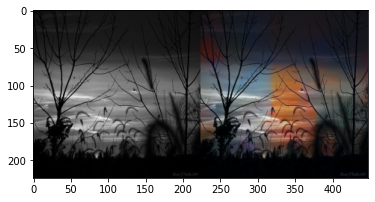

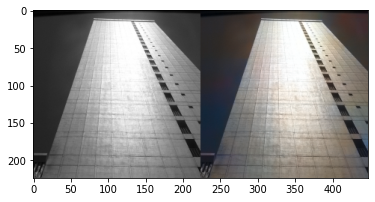

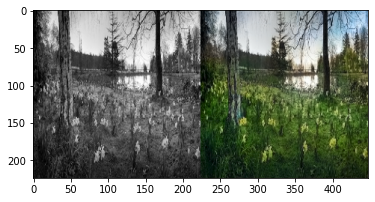

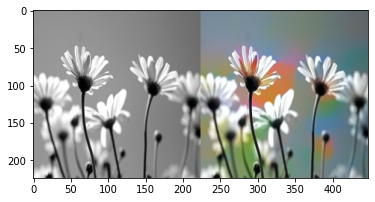

In [0]:
samples = create_sample(model, images_gray, 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))

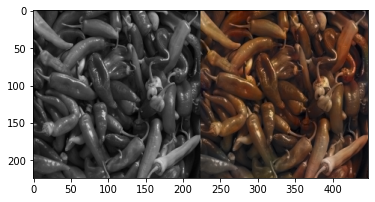

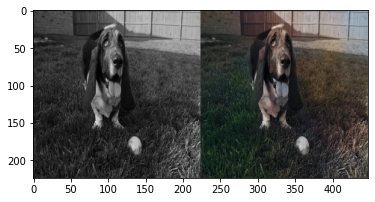

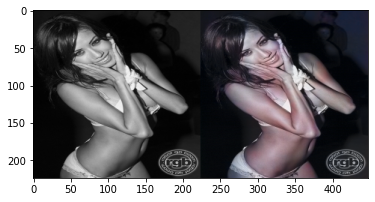

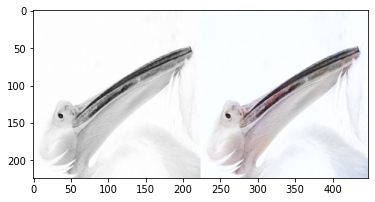

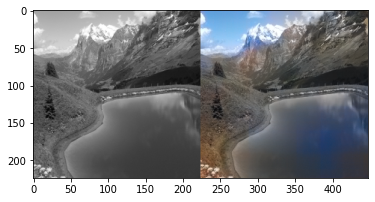

In [0]:
samples = create_sample(model, images_gray, 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))

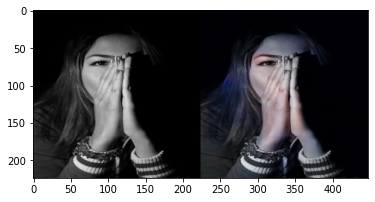

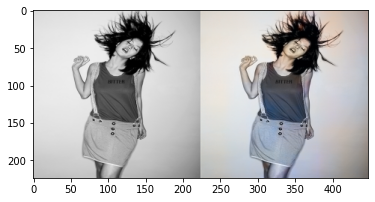

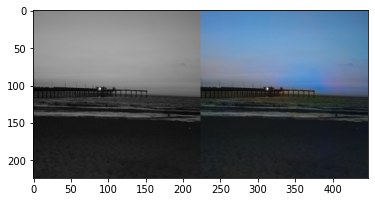

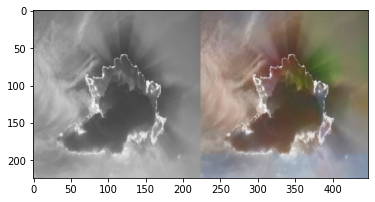

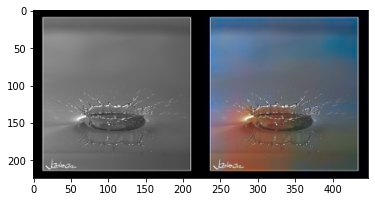

In [0]:
samples = create_sample(model, images_gray, 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))

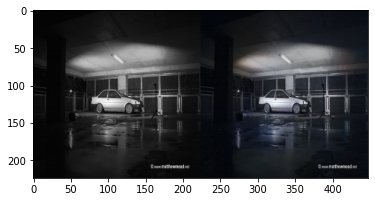

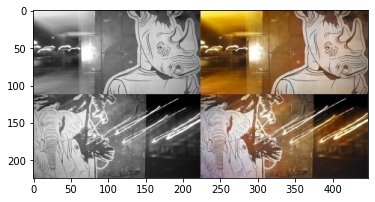

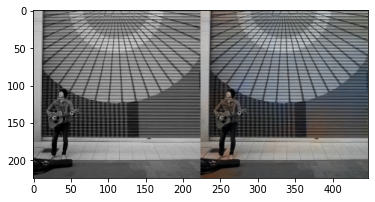

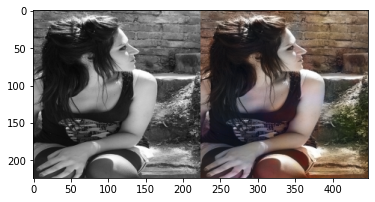

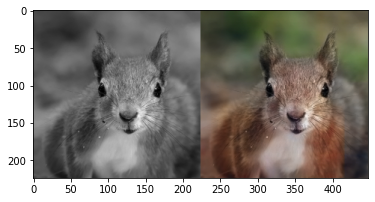

In [0]:
samples = create_sample(model, images_gray, 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))

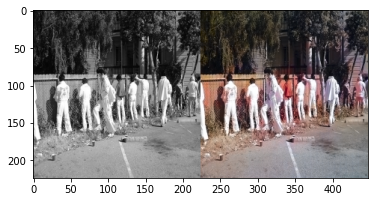

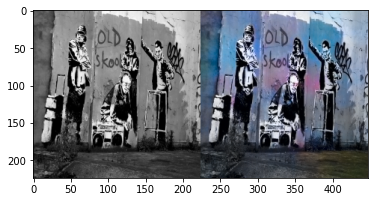

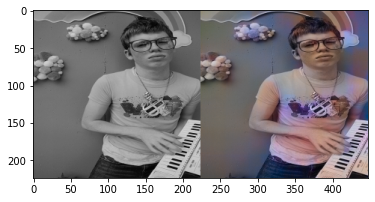

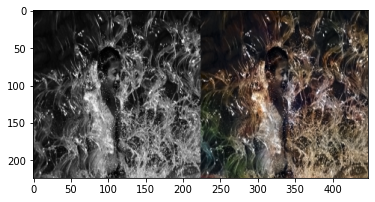

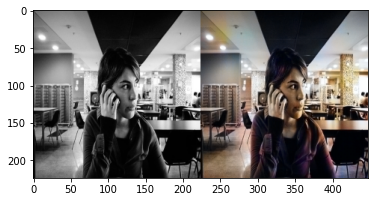

In [0]:
samples = create_sample(model, images_gray, 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))